# Implement a neural network

In [1]:
# Importing libraries

import torch
torch.manual_seed(0)
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
#   Download CIFAR-10 dataset
BATCH_SIZE = 32
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(
             root='./cifar/',
             train=True,
             transform=transform,
             download= True,
             )

# Dataset Loader (Input Pipline)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

#Data.DataLoader(dataset,batch_size=1, shuffle=False, sampler=None, num_workers=0, collate_fn=<function default_collate>, pin_memory=False, drop_last=False)

test_data = datasets.CIFAR10(root='./cifar/', train=False, transform=transform)
test_x = Variable(torch.asarray(test_data.data)).type(torch.FloatTensor)
test_y = torch.asarray(test_data.targets)
test_x = torch.permute(test_x, (0, 3, 1, 2))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar/cifar-10-python.tar.gz to ./cifar/


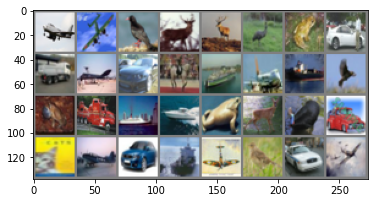

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [5]:
#   Define Neural Network

class Neural_Network(nn.Module):
	# Declaring the Architecture
	def __init__(self):
		super(Neural_Network, self).__init__()
		self.fc1 = nn.Linear(32*32*3, 256)
		self.fc2 = nn.Linear(256, 128)
		self.fc3 = nn.Linear(128, 10)

	# Forward Pass
	def forward(self, x):
		x = x.view(x.shape[0],-1) # Flatten the images
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x


model = Neural_Network()

if torch.cuda.is_available():
	model = model.cuda()
 
 # Declaring Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)


EPOCH = 10

def rightness(predictions, labels):
    pred = torch.max(predictions.data, 1)[1] 
    rights = pred.eq(labels.data.view_as(pred)).sum() 
    return rights, len(labels) 

In [5]:
# Training Neural Network

record = [] 
for epoch in range(EPOCH):  

    train_rights = [] # Record the training accuracies

    for step, (x, y) in enumerate(train_loader):  

        b_x = Variable(x)  
        b_y = Variable(y)  

        model.train() 

        output = model(b_x)  
        loss = criterion(output, b_y)  
        optimizer.zero_grad() 
 
        loss.backward()  
        optimizer.step()

        right = rightness(output, b_y) 
        train_rights.append(right)   


        if step % 200 == 0:

            model.eval()
            test_output = model(test_x)

            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            test_accuracy = (sum(pred_y == test_y).item() / test_y.size(0)) * 100

            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            training_accuracy = 100. * train_r[0].numpy() / train_r[1]

            total_step = len(train_data)//BATCH_SIZE

            print('Epoch [{}/{}], Step [{:4}/{}], Loss: {:.4f} | training accuracy: {:6.2f} % | test accuracy:{:6.2f} %'.format(
                 epoch+1, EPOCH, step+200, total_step, loss.data, training_accuracy, test_accuracy))
            
            record.append((100 - 100. * train_r[0] / train_r[1], 100 - test_accuracy))

Epoch [1/10], Step [ 200/1562], Loss: 2.3115 | training accuracy:   6.25 % | test accuracy: 10.51 %
Epoch [1/10], Step [ 400/1562], Loss: 2.1451 | training accuracy:  20.38 % | test accuracy: 10.97 %
Epoch [1/10], Step [ 600/1562], Loss: 2.0597 | training accuracy:  23.76 % | test accuracy: 10.00 %
Epoch [1/10], Step [ 800/1562], Loss: 1.9433 | training accuracy:  26.13 % | test accuracy: 11.29 %
Epoch [1/10], Step [1000/1562], Loss: 1.7126 | training accuracy:  28.16 % | test accuracy: 12.31 %
Epoch [1/10], Step [1200/1562], Loss: 1.7225 | training accuracy:  29.54 % | test accuracy: 16.29 %
Epoch [1/10], Step [1400/1562], Loss: 1.6554 | training accuracy:  30.84 % | test accuracy: 15.75 %
Epoch [1/10], Step [1600/1562], Loss: 1.7390 | training accuracy:  31.94 % | test accuracy: 17.79 %
Epoch [2/10], Step [ 200/1562], Loss: 1.7850 | training accuracy:  53.12 % | test accuracy: 17.33 %
Epoch [2/10], Step [ 400/1562], Loss: 1.6601 | training accuracy:  39.21 % | test accuracy: 19.55 %


**Evaluate different parameters**

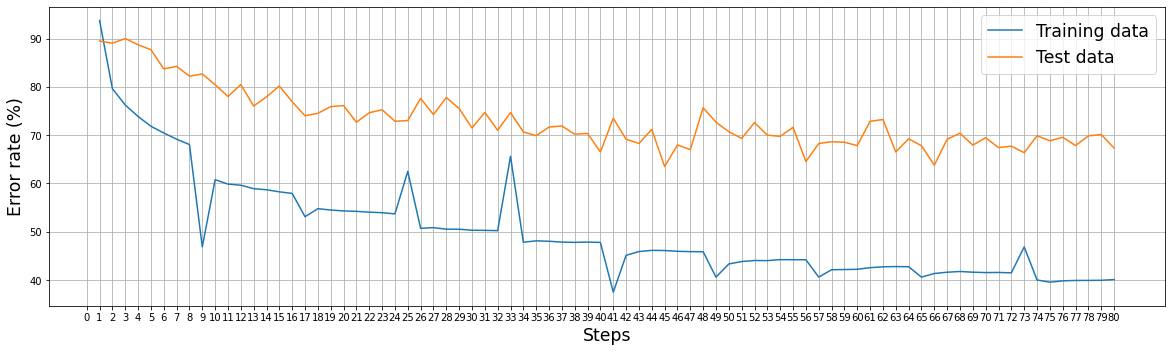

In [6]:
plt.figure(figsize = (20, 5.5))
train_error, test_error = [k[0] for k in record], [k[1] for k in record]
# "record" records the (training error rate, test error rate) in each step
plt.plot(list(range(1,81)), train_error, label= "Training data") 
plt.plot(list(range(1,81)), test_error, label= "Test data") 

plt.xticks(range(0, 81, 1)) 

plt.xlabel('Steps', fontsize = 'xx-large') # Change font size
plt.ylabel('Error rate (%)')
plt.ylabel('Error rate (%)', fontsize = 'xx-large') # Change font size

plt.grid() # Simply add grid by default
plt.legend(fontsize = 'xx-large',  loc= 'upper right')
plt.show()

In [7]:
print('Accuracy of the training images: %.4f %%' % 
      (100 - record[-1][0]))

print('Accuracy of test images: %.4f %%' % 
      (100 - record[-1][1]))

Accuracy of the training images: 59.8791 %
Accuracy of test images: 32.6800 %


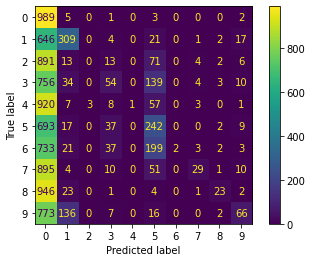

In [8]:
test_output = model(test_x)
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()

confusion_matrix = metrics.confusion_matrix(test_y, pred_y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

# Propose improvements

(a) Convolutional Neural Network

In [9]:
# Defining CNN
cnn = torchvision.models.mobilenet_v3_small(pretrained=True)
print(cnn)

def change_layers(cnn):
    cnn.classifier[3] = nn.Linear(1024, 10, bias=True)
    return cnn


cnn = change_layers(cnn)

if torch.cuda.is_available():
	cnn = cnn.cuda()
 
 # Declaring Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr = 0.01)


# Training CNN Network

record = [] 
for epoch in range(EPOCH):  

    train_rights = [] # Record the training accuracies

    for step, (x, y) in enumerate(train_loader):  

        b_x = Variable(x)  
        b_y = Variable(y)  

        cnn.train() 

        output = cnn(b_x)  
        loss = criterion(output, b_y)  
        optimizer.zero_grad() 
 
        loss.backward()  
        optimizer.step()

        right = rightness(output, b_y)
        train_rights.append(right)   


        if step % 200 == 0:

            cnn.eval()
            test_output = cnn(test_x)

            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            test_accuracy = (sum(pred_y == test_y).item() / test_y.size(0)) * 100

            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            training_accuracy = 100. * train_r[0].numpy() / train_r[1]

            total_step = len(train_data)//BATCH_SIZE

            print('Epoch [{}/{}], Step [{:4}/{}], Loss: {:.4f} | training accuracy: {:6.2f} % | test accuracy:{:6.2f} %'.format(
                 epoch+1, EPOCH, step+200, total_step, loss.data, training_accuracy, test_accuracy))
            
            record.append((100 - 100. * train_r[0] / train_r[1], 100 - test_accuracy))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

**Evaluate different parameters**

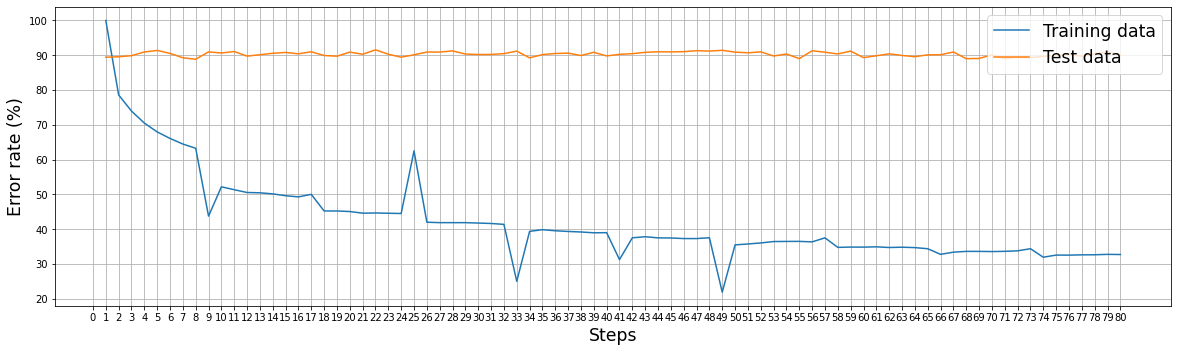

In [10]:
plt.figure(figsize = (20, 5.5))
train_error, test_error = [k[0] for k in record], [k[1] for k in record]
# "record" records the (training error rate, test error rate) in each step
plt.plot(list(range(1,81)), train_error, label= "Training data") 
plt.plot(list(range(1,81)), test_error, label= "Test data") 

plt.xticks(range(0, 81, 1)) 

plt.xlabel('Steps', fontsize = 'xx-large') # Change font size
plt.ylabel('Error rate (%)')
plt.ylabel('Error rate (%)', fontsize = 'xx-large') # Change font size

plt.grid() # Simply add grid by default
plt.legend(fontsize = 'xx-large',  loc= 'upper right')
plt.show()

In [11]:
print('Accuracy of the training images: %.4f %%' % 
      (100 - record[-1][0]))

print('Accuracy of test images: %.4f %%' % 
      (100 - record[-1][1]))

Accuracy of the training images: 67.2912 %
Accuracy of test images: 9.9700 %


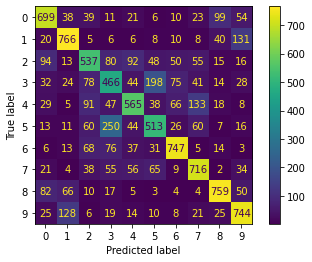

In [12]:
test_output = cnn(test_x)
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()

confusion_matrix = metrics.confusion_matrix(test_y, pred_y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

# Propose improvements

(b) Dropout

In [6]:
# Defining CNN
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = nn.functional.dropout(x, p=0.1, training=self.training)
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

cnn = CNN()

if torch.cuda.is_available():
	cnn = cnn.cuda()
 
 # Declaring Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr = 0.01)

# Training CNN Network
EPOCH = 30

record = [] 
for epoch in range(EPOCH):  

    train_rights = [] # Record the training accuracies

    for step, (x, y) in enumerate(train_loader):  

        b_x = Variable(x)  
        b_y = Variable(y)  

        cnn.train() 

        output = cnn(b_x)  
        loss = criterion(output, b_y)  
        optimizer.zero_grad() 
 
        loss.backward()  
        optimizer.step()

        right = rightness(output, b_y) # (outputs, labels) = (correct numbers, all samples)
        train_rights.append(right)   


        if step % 200 == 0:

            cnn.eval()
            test_output = cnn(test_x)

            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            test_accuracy = (sum(pred_y == test_y).item() / test_y.size(0)) * 100

            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            training_accuracy = 100. * train_r[0].numpy() / train_r[1]

            total_step = len(train_data)//BATCH_SIZE

            print('Epoch [{}/{}], Step [{:4}/{}], Loss: {:.4f} | training accuracy: {:6.2f} % | test accuracy:{:6.2f} %'.format(
                 epoch+1, EPOCH, step+200, total_step, loss.data, training_accuracy, test_accuracy))
            
            record.append((100 - 100. * train_r[0] / train_r[1], 100 - test_accuracy))

Epoch [1/30], Step [ 200/1562], Loss: 2.3026 | training accuracy:  12.50 % | test accuracy: 11.02 %
Epoch [1/30], Step [ 400/1562], Loss: 2.2991 | training accuracy:  10.96 % | test accuracy: 10.74 %
Epoch [1/30], Step [ 600/1562], Loss: 2.3058 | training accuracy:  12.13 % | test accuracy: 10.01 %
Epoch [1/30], Step [ 800/1562], Loss: 2.2703 | training accuracy:  13.37 % | test accuracy: 10.16 %
Epoch [1/30], Step [1000/1562], Loss: 2.2658 | training accuracy:  14.56 % | test accuracy:  9.99 %
Epoch [1/30], Step [1200/1562], Loss: 2.1892 | training accuracy:  15.66 % | test accuracy:  9.94 %
Epoch [1/30], Step [1400/1562], Loss: 2.1755 | training accuracy:  17.01 % | test accuracy: 10.00 %
Epoch [1/30], Step [1600/1562], Loss: 1.9915 | training accuracy:  18.27 % | test accuracy:  9.99 %
Epoch [2/30], Step [ 200/1562], Loss: 1.9474 | training accuracy:  21.88 % | test accuracy: 10.15 %
Epoch [2/30], Step [ 400/1562], Loss: 1.9073 | training accuracy:  29.14 % | test accuracy: 10.24 %


**Evaluate different parameters**

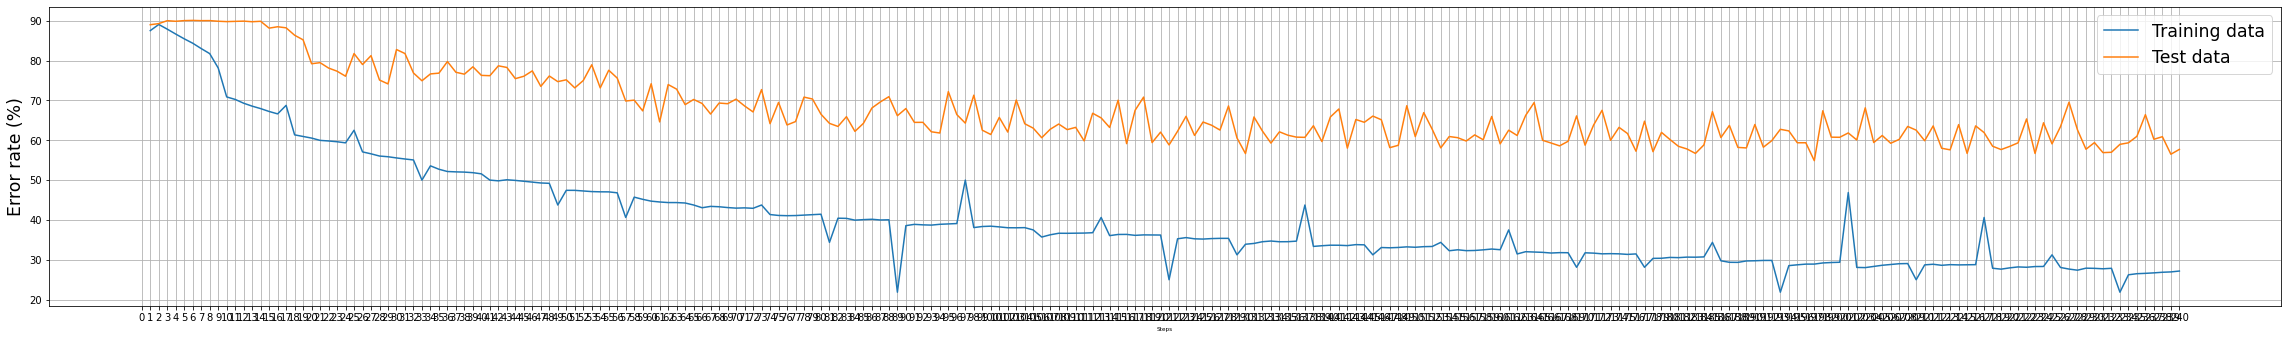

In [12]:
plt.figure(figsize = (40, 5.5))
train_error, test_error = [k[0] for k in record], [k[1] for k in record]
# "record" records the (training error rate, test error rate) in each step
plt.plot(list(range(1,241)), train_error, label= "Training data") 
plt.plot(list(range(1,241)), test_error, label= "Test data") 

plt.xticks(range(0, 241, 1)) 

plt.xlabel('Steps', fontsize = 'xx-small') # Change font size
plt.ylabel('Error rate (%)')
plt.ylabel('Error rate (%)', fontsize = 'xx-large') # Change font size

plt.grid() # Simply add grid by default
plt.legend(fontsize = 'xx-large',  loc= 'upper right')
plt.show()

In [13]:
print('Accuracy of the training images: %.4f %%' % 
      (100 - record[-1][0]))

print('Accuracy of test images: %.4f %%' % 
      (100 - record[-1][1]))

Accuracy of the training images: 72.8163 %
Accuracy of test images: 42.3000 %


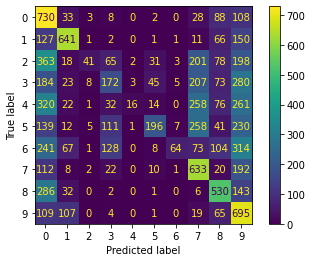

In [14]:
test_output = cnn(test_x)
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()

confusion_matrix = metrics.confusion_matrix(test_y, pred_y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()